<a href="https://colab.research.google.com/github/MahaleVivek/HandsOn-LLMs/blob/modules/modules/Ch11_Finetuning_representation_models_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Supervised Classification

In [ ]:
### Fine-Tuning a Pretrained BERT Model

In [ ]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

# Prepare data and splits
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
#We define the number of labels that we want to predict beforehand. This is necessary to
# create the feedforward neural network that is applied on top of our pretrained model:

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load model and tokenizer
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# Tokenize our data

In [ ]:
from transformers import DataCollatorWithPadding

# Pad to the longest sequence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
   """Tokenize input data"""
   return tokenizer(examples["text"], truncation=True)

# Tokenize train/test data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8530
})

In [ ]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})

In [ ]:
tokenized_test

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1066
})

In [ ]:
test_data

Dataset({
    features: ['text', 'label'],
    num_rows: 1066
})

In [ ]:
train_data[0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

In [ ]:
tokenized_train[0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1,
 'input_ids': [101,
  1103,
  2067,
  1110,
  17348,
  1106,
  1129,
  1103,
  6880,
  1432,
  112,
  188,
  1207,
  107,
  14255,
  1389,
  107,
  1105,
  1115,
  1119,
  112,
  188,
  1280,
  1106,
  1294,
  170,
  24194,
  1256,
  3407,
  1190,
  170,
  11791,
  5253,
  188,
  1732,
  7200,
  10947,
  12606,
  2895,
  117,
  179,
  7766,
  118,
  172,
  15554,
  1181,
  3498,
  6961,
  3263,
  1137,
  188,
  1566,
  7912,
  14516,
  6997,
  119,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  

#### Before creating the Trainer, we will want to prepare a special DataCollator.
> A DataCollator is a class that helps us build batches of data but also allows us to apply data augmentation.

In [ ]:
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import evaluate

def compute_metrics(eval_pred):
   """Calculate F1 score"""
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)

   load_f1 = evaluate.load("accuracy")
   f1 = load_f1.compute(predictions=predictions, references=labels)["accuracy"]
   return {"accuracy": f1}

#### With compute_metrics we can define any number of metrics that we are interested in and that can be printed out or logged during training. This is especially helpful during training as it allows for detecting overfitting behavior.

In [ ]:
# Instantiate Trainer

from transformers import TrainingArguments, Trainer

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

In [ ]:
# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

<ipython-input-24-2157897e7954>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# The TrainingArguments class defines hyperparameters we want to tune, such as the
# learning rate and how many epochs (rounds) we want to train. The Trainer is used to execute the training process.

In [ ]:
trainer.evaluate()

{'eval_loss': 0.7012843489646912,
 'eval_model_preparation_time': 0.0166,
 'eval_accuracy': 0.49906191369606,
 'eval_runtime': 3.8489,
 'eval_samples_per_second': 276.959,
 'eval_steps_per_second': 17.407}

### Freezing Layers

To further showcase the importance of training the entire network, the next example will demonstrate how you can use Hugging Face Transformers to freeze certain layers of your network.

We will freeze the main BERT model and allow only updates to pass through the classification head. This will be a great comparison as we will keep everything the same, except for freezing specific layers.



In [27]:
# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# Print layer names
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

Our pretrained BERT model contains a lot of layers that we can potentially freeze. Inspecting these layers gives insight into the structure of the network and what we might want to freeze:

We could choose to only freeze certain layers to speed up computing but still allow the main model to learn from the classification task. Generally, we want frozen layers to be followed by trainable layers.

We are going to freeze everything except for the classification head

In [29]:
for name, param in model.named_parameters():

     # Trainable classification head
     if name.startswith("classifier"):
        param.requires_grad = True

      # Freeze everything else
     else:
        param.requires_grad = False

we have frozen everything except for the feedforward neural network, which is our classification head.

In [30]:
from transformers import TrainingArguments, Trainer

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()

<ipython-input-30-1da7f8eeebcf>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.685500


TrainOutput(global_step=534, training_loss=0.6852787496445331, metrics={'train_runtime': 40.3793, 'train_samples_per_second': 211.247, 'train_steps_per_second': 13.225, 'total_flos': 227605451772240.0, 'train_loss': 0.6852787496445331, 'epoch': 1.0})

In [31]:
trainer.evaluate()

{'eval_loss': 0.6766408085823059,
 'eval_accuracy': 0.5984990619136961,
 'eval_runtime': 3.9844,
 'eval_samples_per_second': 267.547,
 'eval_steps_per_second': 16.816,
 'epoch': 1.0}

In [32]:
# When we evaluate the model, we only get an accuracy score of 0.59, Instead of
# freezing nearly all layers, let’s freeze everything up until encoder block 10
# and see how it affects performance. A major benefit is that this reduces
# computation but still allows updates to flow through part of the pretrained model:

In [33]:
# Load model
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Encoder block 11 starts at index 165 and
# we freeze everything before that block
for index, (name, param) in enumerate(model.named_parameters()):
    if index < 165:
        param.requires_grad = False

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-33-742930ef214b>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [34]:
trainer.train()

Step,Training Loss
500,0.476100


TrainOutput(global_step=534, training_loss=0.4725381408291363, metrics={'train_runtime': 44.1194, 'train_samples_per_second': 193.339, 'train_steps_per_second': 12.104, 'total_flos': 227605451772240.0, 'train_loss': 0.4725381408291363, 'epoch': 1.0})

In [37]:
# evaluate the result
trainer.evaluate()

{'eval_loss': 0.4100644588470459,
 'eval_accuracy': 0.8105065666041276,
 'eval_runtime': 3.545,
 'eval_samples_per_second': 300.701,
 'eval_steps_per_second': 18.9,
 'epoch': 1.0}

We got an Accuracy score of 0.81, which is much higher than our previous score of 0.59 when freezing all layers. It demonstrates that although we generally want to train as many layers as possible, you can get away with training less if you do not have the necessary computing power.



---



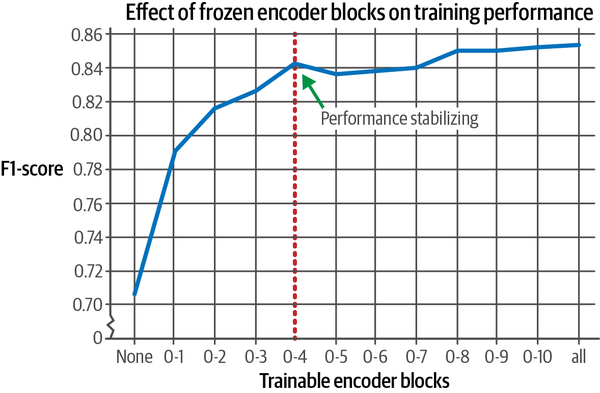

To further illustrate this effect, we tested the effect of iteratively freezing encoder blocks and fine-tuning them as we did thus far. training only the first five encoder blocks (red vertical line) is enough to almost reach the performance of training all encoder blocks.

Note:
When you are training for multiple epochs, the difference (in training time and resources) between freezing and not freezing often becomes larger. It is therefore advised to play around with a balance that works for you.